# Team information

|Team-number :| 1|
|:----:|:----:|


|Name|    E-Mail        |matriculation-nr.|
|:----:|:----:|:----:|
|Tamara Scherer| schere21@ads.uni-passau.de|104218|
|Felix Müller| muell518@ads.uni-passau.de|104227|


# 1. Data Import

After labeling the data we now import it from the label-studio plattform. Therefore we used the provided workaround and downloaded the pickle file. In the next step we extract the necessary texts with the corresponding labels out of the whole downloaded data. A dataframe is created with the columns "Text" and "Label" in which the extracted data is saved. To be able to work more efficient with the data, we assign an unique ID to each label in the dataframe with the function "categorise()". This is especially helpful when we create the neural network in the end, as we can only use integer values as input. As stated in the task formulation we have to focus on one ID Stage. So, we implemented a filter to get only the entries with the desired ID Stage which can be specified before.

Necessary packages:
> pickle: This package is used for serializing and de-serializing python object structures which means that any kind of python object is converted into byte streams or vice versa.

> pandas: This package is usually used for data analysis and manipulation. It allows us to create and work with a DataFrame.

In [ ]:
#from label_studio_sdk import Client
#from label_studio_sdk import project
#from label_studio_sdk import project
#import pandas as pd
#LABEL_STUDIO_URL = 'http://132.231.59.226:8080' #this address needs to be the same as the address the label-studio is hosted on.
#API_KEY = '1655a8922f821195356a17a3224c0532b091c61d' #please add your personal API_Key here to get your API_Key follow the Pictures below

#ls = Client(url=LABEL_STUDIO_URL, api_key=API_KEY)
#ls.check_connection()
#pro = project.Project.get_from_id(ls,"1")
#tasks = project.Project.get_labeled_tasks(pro)
#tasks[0]

**Download labelled tasks**

In [1]:
# import necessary package
import pickle

# import labeled data from downloaded pickle file
with open("Files/tasks3", 'rb') as f:
    tasks = pickle.load(f)

**Extract text with label**

In [2]:
# import necessary package
import pandas as pd

# filter the necessary texts with the corresponding label
df = pd.DataFrame(columns = ['Text', 'Label',])

for i in range(len(tasks)): 
    for j in range(len(tasks[i]['annotations'][0]['result'])): 
        df = df.append({
            'Text' : tasks[i]['annotations'][0]['result'][j]['value']['text'],
            'Label' : tasks[i]['annotations'][0]['result'][j]['value']['labels']
                        }, ignore_index = True)
df

,Text,Label
0,Good afternoon and thanks a lot for taking my ...,[QID_1]
1,Good afternoon and thanks a lot for taking my...,[Question_1_Company_specific]
2,Good afternoon and thanks a lot for taking my ...,[Question_2_specific]
3,Good afternoon and thanks a lot for taking my ...,[Question_3_neutral]
4,"No, I think that as it relates to the one, I t...",[AID_1]
...,...,...
11289,One of the areas obviously which has been a st...,[Question_3_neutral]
11290,"Well, let's start with the first part of your ...",[AID_1]
11291,"Well, let's start with the first part of your ...",[Answer_1_specific]
11292,"Well, let's start with the first part of your ...",[Answer_2_positive]


**Save Label as unique ID**

In [3]:
# assign a unique number to each label (can also be used later for the neural network)
def categorise(row):  
    if row['Label'] == ['Question_1_Company_specific']:
        return 1
    elif row['Label'] == ['Question_1_Market_related']:
        return 2
    elif row['Label'] == ['Question_2_specific']:
        return 3
    elif row['Label'] == ['Question_2_open']:
        return 4
    elif row['Label'] == ['Question_3_attack']:
        return 5
    elif row['Label'] == ['Question_3_support']:
        return 6
    elif row['Label'] == ['Question_3_neutral']:
        return 7
    elif row['Label'] == ['Answer_1_specific']:
        return 8
    elif row['Label'] == ['Answer_1_avoid_excuse']:
        return 9
    elif row['Label'] == ['Answer_2_positive']:
        return 10
    elif row['Label'] == ['Answer_2_negative']:
        return 11
    elif row['Label'] == ['Answer_3_blame']:
        return 12
    elif row['Label'] == ['Answer_3_no_blame']:
        return 13
    else:
        return 0
    
    
# call function and write results in a new column of the dataframe
df['LabelNumber'] = df.apply(
    lambda row: categorise(row), axis=1)

df

,Text,Label,LabelNumber
0,Good afternoon and thanks a lot for taking my ...,[QID_1],0
1,Good afternoon and thanks a lot for taking my...,[Question_1_Company_specific],1
2,Good afternoon and thanks a lot for taking my ...,[Question_2_specific],3
3,Good afternoon and thanks a lot for taking my ...,[Question_3_neutral],7
4,"No, I think that as it relates to the one, I t...",[AID_1],0
...,...,...,...
11289,One of the areas obviously which has been a st...,[Question_3_neutral],7
11290,"Well, let's start with the first part of your ...",[AID_1],0
11291,"Well, let's start with the first part of your ...",[Answer_1_specific],8
11292,"Well, let's start with the first part of your ...",[Answer_2_positive],10


**Filter one ID stage (e.g. Question_1_XX)**

In [4]:
# set desired labels
idStage = [1, 2]

# filter the entries in the dataframe with the specified ID stage
df = df[df['LabelNumber'].isin(idStage)]

# set new index
df = df.reset_index()
# delete old indices
df.pop('index')

df

,Text,Label,LabelNumber
0,Good afternoon and thanks a lot for taking my...,[Question_1_Company_specific],1
1,"Okay, that's very helpful. And then on your gr...",[Question_1_Company_specific],1
2,"Hi Richard. So, on gross margin, it looked pre...",[Question_1_Market_related],2
3,And the core-on-core was pretty normal for you...,[Question_1_Company_specific],1
4,Okay. And my follow-up is on the EBIT dollar ...,[Question_1_Company_specific],1
...,...,...,...
1304,Hi. This is Mark for Pat. Thank you so much fo...,[Question_1_Company_specific],1
1305,Yes. I'm just wondering if you could talk a li...,[Question_1_Company_specific],1
1306,"Hi, thank you. Congrats on the quarter. Just a...",[Question_1_Company_specific],1
1307,Thanks for squeezing me in guys. This question...,[Question_1_Company_specific],1


In [ ]:
# LabelID = 1 --> 919
# LabelID = 2 --> 390

# 2. Preprocessing

Now we implement different steps to preprocess the downloaded data. Therefore we have to make some imports first. 

Necessary Packages:
> re: This package can be used to work with Regular Expressions. Here it is used remove the numbers in the text.

> string: This package is necessary for common string operations. Here it is used to remove the punctuation in the text.

> nltk: Natural Language Toolkit is a package which is used for Natural Language Processing. Here it is used for stemming, lemmatization, tokenization and the removal of stopwords.

Further Imports:
> For Stemmer: The module "nltk.stem.snowball" provides a port of the Snowball stemmers. The word stemmer is based on the original Porter stemming algorithm for suffix stripping. In this case it is used for the English language.

> For Stopwords: Here the English stopwords are imported from the "nltk.corpus" package. It includes words which does not add much meaning to a sentence and are not important for further text analysis.

> For Tokenization: The word_tokenize module is imported from the nltk library for tokenization.

> For Lemmatizer: The "WordNetLemmatizer" module as well as "pos_tag" is imported here. Therefore the system requires some further downloads.

In the next step we start with the preprocessing. Therefore, we implemented a function called "do_preprocessing" with text that has to be preprocessed as input. Furthermore, it is possible to set two boolean values to specify if the removal of stopwords and the stemming should be executed. 
Within the function we implemented the following steps:
1. Removal of Numbers: delete all numbers, e.g. 1, 2 of the text
2. Lowercasing: convert the text into the same casing, so that the different versions of the word can be treated as one
3. Stemming: process to reduce the words to their root forms, but the stem itself may not be a valid word in the language (here we use the PorterStemmer)
4. Stopwords Removal: stopwords are trivial words which appear very frequently in the text without adding much valuable information and therefore not necessary for the further analysis
5. Removing Punctuations: the punctuation does not add any value, so it is not necessary or helpful for the analysis and can therefore be deleted as well
6. Removing Extra Whitespaces: additional whitespaces do not add any value to the data and just increase the text size, so they can be deleted as well
<p>
For Lemmatization we implemented another function "do_lemmatization" as it is necessary to do a tokenization first.

1. Tokenization: process of splitting the text into pieces called tokens (here the tokens are the single words)
2. Lemmatization: This can be done instead of stemming. Lemmatization is also a process to convert the word to its base form. Before the text is lemmatized a POS tagging is necessary to tag the tokens as noun, verb, adverb or adjective. As it causes noticeable improvement we implement the lemmatization in addition to the already implemented preprocessing.
<p>
Finally we use the resulting tokens to create a dictionary which is necessary for the following steps as for building the neural network the column size of the training and test dataset have to be identical. This can be ensured by using this dictionary. To be able to execute the next implementations it is necessary to convert the tokens back to normal strings.

In [ ]:
#pip install gensim

**Necessary Imports**

In [5]:
# necessary imports for preprocessing steps

# import necessary packages
import re
import string
import nltk

# import a stemmer for english words
snowStem = nltk.stem.SnowballStemmer('english')

# import stopwords
from nltk.corpus import stopwords
en_stopwords = stopwords.words('english')

# import for tokenization
from nltk import word_tokenize
nltk.download('punkt')

# import for lemmatizer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ts23\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ts23\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ts23\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ts23\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

**Preprocessing of the data**

In [6]:
# function that includes all preprocessing steps

def do_preprocessing(text_to_clean, remove_stopwords = True, stemming = True):
    # remove numbers 
    text_to_clean = re.sub(r'\d+', '', text_to_clean)
    # transform text to lower case
    text_to_clean = text_to_clean.lower()

    if stemming:
      # stemming
      text_to_clean = snowStem.stem(text_to_clean)
    
    if remove_stopwords:
        # remove stop words
        text_to_clean = ' '.join([w for w in text_to_clean.split() if not(w in en_stopwords)])

    # remove punctuation
    text_to_clean = text_to_clean.translate(str.maketrans('','', string.punctuation))
    # remove leading and ending white spaces
    text_to_clean = text_to_clean.strip()
    
    return text_to_clean


# call function and write results in new column of the dataframe
df.loc[:, 'CleanText'] = df['Text'].apply(
    lambda x: do_preprocessing(x, True, True))

df

,Text,Label,LabelNumber,CleanText
0,Good afternoon and thanks a lot for taking my...,[Question_1_Company_specific],1,good afternoon thanks lot taking question so r...
1,"Okay, that's very helpful. And then on your gr...",[Question_1_Company_specific],1,okay thats helpful growth china surpass expect...
2,"Hi Richard. So, on gross margin, it looked pre...",[Question_1_Market_related],2,hi richard so gross margin looked pretty solid...
3,And the core-on-core was pretty normal for you...,[Question_1_Company_specific],1,coreoncore pretty normal well
4,Okay. And my follow-up is on the EBIT dollar ...,[Question_1_Company_specific],1,okay followup ebit dollar growth looked like c...
...,...,...,...,...
1304,Hi. This is Mark for Pat. Thank you so much fo...,[Question_1_Company_specific],1,hi mark pat thank much taking question could t...
1305,Yes. I'm just wondering if you could talk a li...,[Question_1_Company_specific],1,yes im wondering could talk little bit custome...
1306,"Hi, thank you. Congrats on the quarter. Just a...",[Question_1_Company_specific],1,hi thank you congrats quarter followup toms qu...
1307,Thanks for squeezing me in guys. This question...,[Question_1_Company_specific],1,thanks squeezing guys question you john know g...


**Lemmatization**

In [7]:
# function for lemmatization
def do_lemmatization(text):
    
  text = word_tokenize(text)
  
  result=[]
  wordnet = WordNetLemmatizer()
  for token,tag in pos_tag(text):
        pos=tag[0].lower()
        
        if pos not in ['a', 'r', 'n', 'v']:
            pos='n'
            
        result.append(wordnet.lemmatize(token,pos))

  return result

# call function
df['CleanText'] = df['CleanText'].apply(
    lambda x: do_lemmatization(x))

df

,Text,Label,LabelNumber,CleanText
0,Good afternoon and thanks a lot for taking my...,[Question_1_Company_specific],1,"[good, afternoon, thanks, lot, take, question,..."
1,"Okay, that's very helpful. And then on your gr...",[Question_1_Company_specific],1,"[okay, thats, helpful, growth, china, surpass,..."
2,"Hi Richard. So, on gross margin, it looked pre...",[Question_1_Market_related],2,"[hi, richard, so, gross, margin, look, pretty,..."
3,And the core-on-core was pretty normal for you...,[Question_1_Company_specific],1,"[coreoncore, pretty, normal, well]"
4,Okay. And my follow-up is on the EBIT dollar ...,[Question_1_Company_specific],1,"[okay, followup, ebit, dollar, growth, look, l..."
...,...,...,...,...
1304,Hi. This is Mark for Pat. Thank you so much fo...,[Question_1_Company_specific],1,"[hi, mark, pat, thank, much, take, question, c..."
1305,Yes. I'm just wondering if you could talk a li...,[Question_1_Company_specific],1,"[yes, im, wondering, could, talk, little, bit,..."
1306,"Hi, thank you. Congrats on the quarter. Just a...",[Question_1_Company_specific],1,"[hi, thank, you, congrats, quarter, followup, ..."
1307,Thanks for squeezing me in guys. This question...,[Question_1_Company_specific],1,"[thanks, squeeze, guy, question, you, john, kn..."


**Create dictionary**

In [8]:
from gensim import corpora

# generate the gensim dictionary
dct = corpora.dictionary.Dictionary(df['CleanText']).values()

**Convert tokens to strings**

In [9]:
# convert tokens back to strings for further processing
whitespace = " "
df['CleanText'] = df['CleanText'].apply(
    lambda x: whitespace.join(x))

df

,Text,Label,LabelNumber,CleanText
0,Good afternoon and thanks a lot for taking my...,[Question_1_Company_specific],1,good afternoon thanks lot take question so rec...
1,"Okay, that's very helpful. And then on your gr...",[Question_1_Company_specific],1,okay thats helpful growth china surpass expect...
2,"Hi Richard. So, on gross margin, it looked pre...",[Question_1_Market_related],2,hi richard so gross margin look pretty solid w...
3,And the core-on-core was pretty normal for you...,[Question_1_Company_specific],1,coreoncore pretty normal well
4,Okay. And my follow-up is on the EBIT dollar ...,[Question_1_Company_specific],1,okay followup ebit dollar growth look like com...
...,...,...,...,...
1304,Hi. This is Mark for Pat. Thank you so much fo...,[Question_1_Company_specific],1,hi mark pat thank much take question could tal...
1305,Yes. I'm just wondering if you could talk a li...,[Question_1_Company_specific],1,yes im wondering could talk little bit custome...
1306,"Hi, thank you. Congrats on the quarter. Just a...",[Question_1_Company_specific],1,hi thank you congrats quarter followup tom que...
1307,Thanks for squeezing me in guys. This question...,[Question_1_Company_specific],1,thanks squeeze guy question you john know guy ...


# 3. Split of training and test dataset

For the neural network which we build later on, it is necessary to split the available data in a training and a test dataset. We therefore use the 70/30-approach which means that 70% of the data is used for training and 30% of the data is used for testing. 
We do this split already in this step to ensure that there are no dependencies between training and test dataset in the end.

Necessary package:
> numpy: Provides operations on arrays, including mathematical, logical, shape manipulation, sorting, selecting, I/O, basic linear algebra and much more. We use it here to compute the training_size

In [ ]:
#import numpy as np

#training_fraction = 0.70
#training_size = int(np.floor(len(df) * training_fraction))

#data_train, data_test = df[:training_size], df[training_size:]

In [10]:
import random

# we arbitrarily use a training fraction of 70%
train_size = int(0.70 * len(df))

# select random index numbers and split the data accordingly
random.seed(42)
train_select = random.sample(list(df.index), k = train_size)
train_idx = [i for i in list(df.index) if i in train_select]
test_idx = [i for i in list(df.index) if not(i in train_select)]
data_train = df.iloc[train_idx, :]
data_test = df.iloc[test_idx, :]

# 4.1 Frequency Method: Bag-of-Words (BOW)

In this approach the number of terms per document are counted. As we have a big corpora in this case, the resulting document-term matrix is a sparse matrix which means that it has many zeros and only a few non-zeor entries.
The method "CountVectorizer()" converts a collection of text documents to a matrix of token counts. The result out of this is a sparse representation of the counts which then have to be transformed into an array. Finally, this array is converted in a DataFrame. 
As already mentioned before, we have created a dictionary out of all the existing tokens after the preprocessing. This dictionary can now be used as input for the CountVectorizer() to get BOW-matrices with the same amount of columns.
<p>
Necessary Package: 

> sklearn.feature_extraction.text.CountVectorizer: Used to convert a collection of text documents to a matrix of token counts. It produces a sparse representation of the counts.

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

def do_bow(data):
    count_vec = CountVectorizer(vocabulary = dct)

    bow = count_vec.fit_transform(data['CleanText'])
    bow_matrix = pd.DataFrame(data = bow.toarray(), columns = count_vec.get_feature_names_out())

    display(bow_matrix)
    
    return(bow_matrix)

# call function
train_bow_matrix = do_bow(data_train)
test_bow_matrix = do_bow(data_test)

,afternoon,anniversary,benefit,decision,different,do,drive,give,good,growth,...,realignment,rpo,shed,asics,hock,jericho,optical,performing,tomahawk,trident
0,1,1,1,1,1,1,2,1,1,2,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
911,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
912,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
913,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
914,0,0,0,0,0,0,0,1,0,0,...,0,2,1,0,0,0,0,0,0,0


,afternoon,anniversary,benefit,decision,different,do,drive,give,good,growth,...,realignment,rpo,shed,asics,hock,jericho,optical,performing,tomahawk,trident
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
389,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
390,0,0,0,0,0,0,1,1,1,4,...,0,0,0,0,0,0,0,0,0,0
391,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 4.2 Frequency Method: TF-IDF

Another raw frequency-based approach is TF-IDF (= term-frequency inverse-docmument-frequency). Instead of using the absolute term frequencies, we use weighted frequencies for this method.
It is working very similar to the implementation of BOW. For this method the "TfidfVectorizer()" can be used which has again the parameter vocabulary which we set to the created dictionary. The TfidfVectorizer converts a collection of raw documents to a matrix of TF-IDF features. We again get a sparse matrix which we then transform into an array and pass it into a DataFrame which is then given as output of the function.
<p>
Necessary package: 

> sklearn.feature_extraction.text.TfidfVectorizer: used to transform a count matrix to a normalized tf or tf-idf representation.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

def do_tfidf(data):
    tfidf_vec = TfidfVectorizer(vocabulary = dct)

    tfidf = tfidf_vec.fit_transform(data['CleanText'])
    tfidf_matrix = pd.DataFrame(data = tfidf.toarray(), columns = tfidf_vec.get_feature_names_out())

    display(tfidf_matrix)
    
    return(tfidf_matrix)

# call function
train_tfidf_matrix = do_tfidf(data_train)
test_tfidf_matrix = do_tfidf(data_test)

# 5. Topic Method: LSA

LSA (= latent semantic analysis) is one representative of topic-based approaches. It is a mathematical decomposition technique using raw frequency matrices. As already mentioned, BOW or TF-IDF matrices can be very spare and high dimensional. LSA is facing this problem by reducing the dimensionality.
Therefore, the resulting matrix of BOW or TF-IDF is necessary which we already get as output of the corresponding functions. So, we use for example the tf-idf-matrix as input for this function. Then we set the number of topics and apply singular value decomposition to the matrix which can be done for example by the function "svds".
<p>
Necessary Package:

> scipy.sparse.linalg.svds: It is used to make a partial singular value decomposition of a sparse matrix.

In [ ]:
from scipy.sparse.linalg import svds

def do_lsa(data):
    num_components = 10
    q, s, p = svds(data, k = num_components)

    lsa_doc_matrix = pd.DataFrame(data=q)

    display(lsa_doc_matrix)

    return(lsa_doc_matrix)

# call function
train_lsa_matrix = do_lsa(train_tfidf_matrix)
test_lsa_matrix = do_lsa(test_tfidf_matrix)

# 6. Word Embedding Method: Doc2Vec

With the Doc2Vec method it is possible to derive document vectors. As opposite to Word2Vec it is used to create a vectorized representation of a group of words taken collectively as a single unit.
First of all we have to train the model. In order to do this we need the tagged document which can be created by using "models.doc2vec.TaggedDocument()". In the next step we initialise the model, build the vocabulary and train the Doc2Vec model. Finally, we can use the model.infer_vector() to analyse the output and save the matrix as a DataFrame.

<p>
Necessary Package:

> gensim: Used for topic modelling, document indexing and similarity retrieval with large corpora. The target audience is the natural language processing and information retrieval community.

> gensim.models.doc2vec.Doc2Vec: Necessary to build the Doc2Vec model.

In [ ]:
import gensim
from gensim.models.doc2vec import Doc2Vec

def do_doc2vec(data):
    tagged_documents = []
    sentences = [text.split() for text in data['CleanText']]
    doc2vec_alldocs = []

    # train the doc2vec
    for i, doc in enumerate(sentences):
        tagged_documents.append(gensim.models.doc2vec.TaggedDocument(doc, [i]))

    # initialize the model
    d2v = Doc2Vec(vector_size=50, min_count=2, epochs=40)
    # build the vocabulary
    d2v.build_vocab(tagged_documents)

    # train the doc2vec model
    d2v.train(tagged_documents, total_examples=d2v.corpus_count, epochs=d2v.epochs)

    # create Doc2Vec-matrix out of all documents and pass it into a DataFrame
    for i in range(len(tagged_documents)):
        doc2vec_alldocs.append(d2v.infer_vector(tagged_documents[i].words))
    doc2vec_alldocs_matrix = pd.DataFrame(doc2vec_alldocs)

    display(doc2vec_alldocs_matrix)
    
    return(doc2vec_alldocs_matrix)

# call function
train_doc2vec_matrix = do_doc2vec(data_train) 
test_doc2vec_matrix = do_doc2vec(data_test)

# 7. Generating a Neural Network

In the last step we have to create a neural network to generate a target model that tries to predict the correct label for a text. Therefore we first define the neural network. By compilation we define the loww function which is supposed to be minimized and which optimization method should be used. Before we can fit the model, we have to convert the independent variables to an array. In the end we plot the results and calculate the correlation coefficients for the training and test data. <p>
As input for the function we use the prepared dataframe with the preprocessed data and the output of BOW/TF-IDF/LSA/Doc2Vec.


<p>
Necessary Packages:

> tensorflow: Provides various tools for machine learning applications. We need it in the following to generate the neural networks.

> matplotlib.pyplot: It is used for plotting the results.

In [13]:
import numpy as np

In [14]:
train_y = np.array(data_train['LabelNumber'].values.tolist())
test_y = np.array(data_test['LabelNumber'].values.tolist())

In [15]:
train_bow_matrix = np.asarray(train_bow_matrix)
test_bow_matrix = np.asarray(test_bow_matrix)

In [16]:
# import necessary packages
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# define function to create a neural network
def build_nn(train_X, train_y, test_X, test_y):

    # first we define the network, units is the number of neurons, in the first layer we need to tell the model the input shape
    neural_network = tf.keras.Sequential([
                        # hidden layer
                        tf.keras.layers.Dense(units = 100, input_shape = [train_X.shape[1]], activation = 'selu'),
                        # output layer - as we want probability predictions, it is important to use the sigmoid activation
                        tf.keras.layers.Dense(1, activation = 'sigmoid')
    ])

    # compilation
    neural_network.compile(loss = 'binary_crossentropy', optimizer = 'sgd',  metrics = ['accuracy', tf.keras.metrics.Recall()])

    # a summary for all parameters which need to be estimated
    neural_network.summary()

    # convert input to array for the model fit
    train_X = np.asarray(train_X)
    test_X = np.asarray(test_X)

    # we fit the model, epochs is the number of steps which are repeated using gradient descent
    history = neural_network.fit(train_X, train_y, epochs = 100, validation_data = (test_X, test_y))
    plt.plot(history.history['loss'], label = 'training'), plt.plot(history.history['val_loss'], label = 'test'), plt.legend(loc='lower left'), plt.show()

    # correlation coefficient of training and test data
    corrcoef_train = np.corrcoef(neural_network.predict(train_X).flatten(), train_y)[0, 1]    
    print("Correlation coefficient train-data:", corrcoef_train)
    
    corrcoef_test = np.corrcoef(neural_network.predict(test_X).flatten(), test_y)[0, 1]
    print("Correlation coefficient test-data:", corrcoef_test)

    return neural_network

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               449600    
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 449,701
Trainable params: 449,701
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
29/29 [==============================] - 1s 18ms/step - loss: -0.0619 - accuracy: 0.6998 - recall: 0.9858 - val_loss: -0.5748 - val_accuracy: 0.6921 - val_recall: 1.0000
Epoch 2/100
29/29 [==============================] - 0s 6ms/step - loss: -0.8873 - accuracy: 0.7063 - recall: 1.0000 - val_loss: -1.2529 - val_accuracy: 0.6921 - val_recall: 1.0000
Epoch 3/100
29/29 [==============================] - 0s 6ms/step - loss: -1.5650 - 

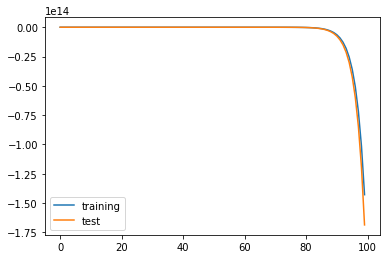

Correlation coefficient train-data: nan
Correlation coefficient test-data: nan


C:\Users\ts23\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\ts23\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [17]:
nn_bow = build_nn(train_bow_matrix, train_y, test_bow_matrix, test_y)

In [ ]:
nn_tfidf = build_nn(train_tfidf_matrix, train_y, test_tfidf_matrix, test_y)

In [ ]:
nn_lsa = build_nn(train_lsa_matrix, train_y, test_lsa_matrix, test_y)

In [ ]:
nn_doc2vec = build_nn(train_doc2vec_matrix, train_y, test_doc2vec_matrix, test_y)

In [ ]:
# for the resampling
from imblearn.under_sampling import RandomUnderSampler

def undersampling(data):
    rus = RandomUnderSampler(sampling_strategy=1)
    data_res, label_res = rus.fit_resample(data, data['LabelNumber'])

    ax = data_res['LabelNumber'].value_counts().plot.pie()
    display(data_res)
    return data_res

df = undersampling(df)

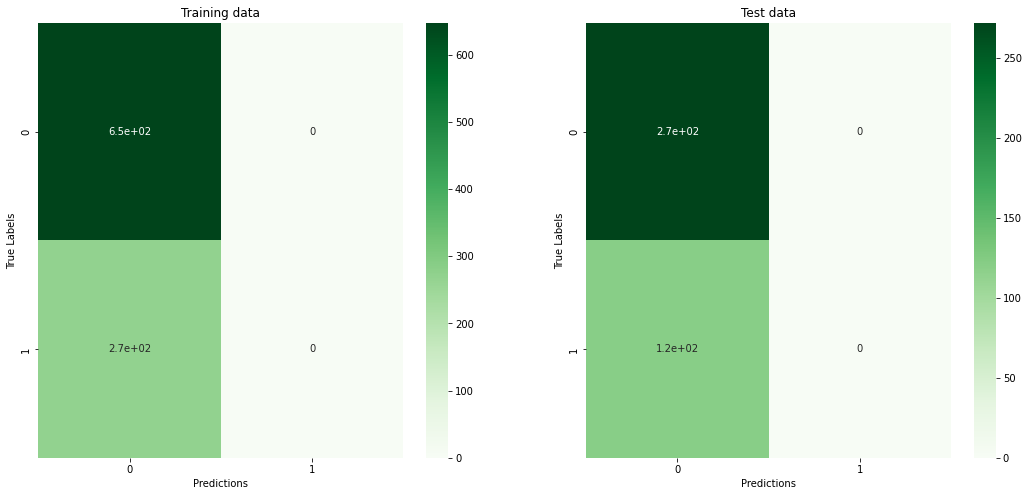

In [19]:
import seaborn as sn
from sklearn.metrics import confusion_matrix
import matplotlib.pylab as plt

neural_network = nn_bow

# let us take a look at the confusion matrix, remember predictions are 1 if the predicted proability for class 1 is higher than 0.5
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

train_cm = confusion_matrix(train_y, (neural_network.predict(train_bow_matrix) > 0.50).ravel() * 1)
sn.heatmap(train_cm, annot = True, cmap='Greens', ax = axs[0])

axs[0].set_xlabel('Predictions')
axs[0].set_ylabel('True Labels')
axs[0].set_title('Training data')

test_cm = confusion_matrix(test_y, (neural_network.predict(test_bow_matrix) > 0.50).ravel() * 1)
sn.heatmap(test_cm, annot = True, cmap='Greens', ax = axs[1])

axs[1].set_xlabel('Predictions')
axs[1].set_ylabel('True Labels')
axs[1].set_title('Test data')

plt.show()

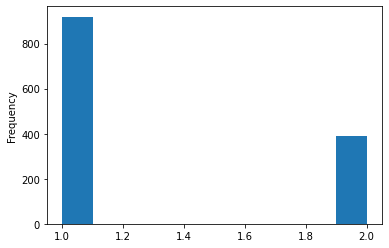

In [20]:
import matplotlib.pylab as plt

# take a look at the distribution of non-churners and churners
df['LabelNumber'].plot(kind = 'hist')
plt.show() 

In [22]:
from imblearn.over_sampling import SMOTENC

# we use SMOTENC which is capable for mixed features (numerical and categorical)
# synthetic observations for categorical features are chosen by majority categories per feature
# see some information here: https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTENC.html#imblearn.over_sampling.SMOTENC
# we need to tell SMOTENC which features are categorical

smt = SMOTENC(categorical_features = list(range(14, 37)), sampling_strategy = 1)
X_train_sm, y_train_sm = smt.fit_resample(train_bow_matrix, train_y)

In [36]:
counter_1 = 0
counter_2 = 0

for i in range (1293):
    if y_train_sm[i] == 1:
        counter_1 = counter_1 + 1
    elif y_train_sm[i] == 2:
        counter_2 = counter_2 +1

In [37]:
counter_1

647

In [38]:
counter_2

646

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 100)               449600    
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 449,701
Trainable params: 449,701
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
41/41 [==============================] - 1s 10ms/step - loss: -0.3508 - accuracy: 0.4730 - recall_1: 0.9621 - val_loss: -0.8554 - val_accuracy: 0.6921 - val_recall_1: 1.0000
Epoch 2/100
41/41 [==============================] - 0s 4ms/step - loss: -2.0929 - accuracy: 0.5000 - recall_1: 1.0000 - val_loss: -2.1371 - val_accuracy: 0.6921 - val_recall_1: 1.0000
Epoch 3/100
41/41 [==============================] - 0s 5ms/step - loss: 

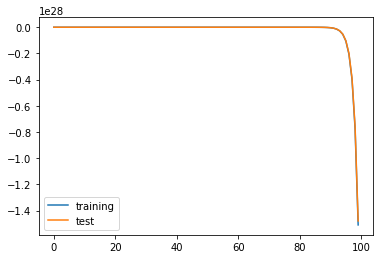

Correlation coefficient train-data: nan
Correlation coefficient test-data: nan


C:\Users\ts23\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\ts23\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [23]:
nn_bow_new = build_nn(X_train_sm, y_train_sm, test_bow_matrix, test_y)

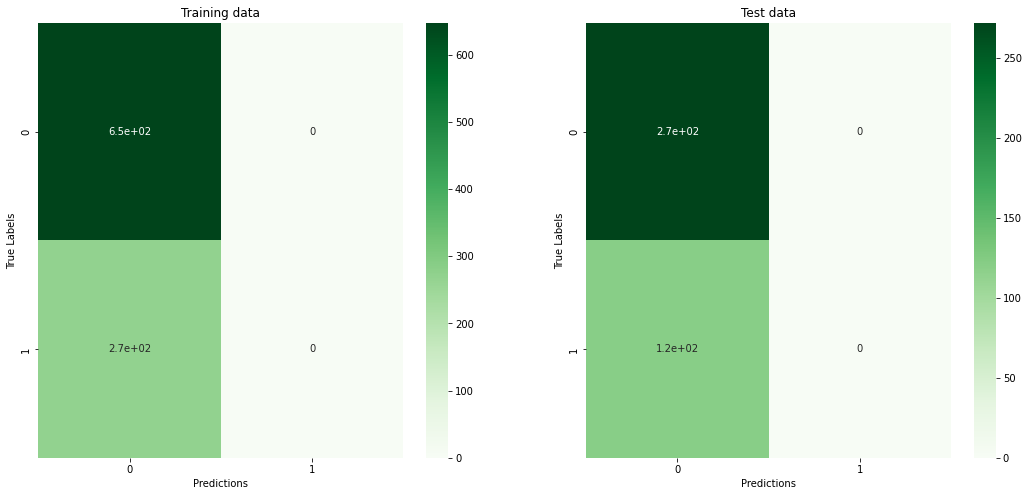

In [25]:
import seaborn as sn
from sklearn.metrics import confusion_matrix
import matplotlib.pylab as plt

neural_network = nn_bow_new

# let us take a look at the confusion matrix, remember predictions are 1 if the predicted proability for class 1 is higher than 0.5
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

train_cm = confusion_matrix(train_y, (neural_network.predict(train_bow_matrix) > 0.50).ravel() * 1)
sn.heatmap(train_cm, annot = True, cmap='Greens', ax = axs[0])

axs[0].set_xlabel('Predictions')
axs[0].set_ylabel('True Labels')
axs[0].set_title('Training data')

test_cm = confusion_matrix(test_y, (neural_network.predict(test_bow_matrix) > 0.50).ravel() * 1)
sn.heatmap(test_cm, annot = True, cmap='Greens', ax = axs[1])

axs[1].set_xlabel('Predictions')
axs[1].set_ylabel('True Labels')
axs[1].set_title('Test data')

plt.show()